In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, SimpleRNN, GRU
from tensorflow.keras import regularizers, Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras
from keras import utils

import sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
path = "/content/drive/MyDrive/NeuralNetworks/windpower.csv"

In [ ]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv(path,
                 parse_dates=["dt"]).iloc[:50000]
df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [ ]:
# How many samples do we have?
len(df)

50000

In [ ]:
# Dtypes of various columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      50000 non-null  datetime64[ns]
 1   MW      50000 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 781.4 KB


In [ ]:
# Define the split time
split_ratio = 0.8  # 80% for the training set
split_time = int(len(df) * split_ratio)

# Get the train set
time_train = df['dt'].iloc[:split_time]
x_train = df['MW'].iloc[:split_time]

# Get the validation set
time_valid = df['dt'].iloc[split_time:]
x_valid = df['MW'].iloc[split_time:]



#train_size = int(df.shape[0]*0.8)
#train_df = df.iloc[:train_size]
#val_df = df.iloc[train_size:]

In [ ]:
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='dt', ascending=True)

In [ ]:
df.set_index('dt', inplace=True)
df.head()

,MW
dt,
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0


In [ ]:
# get the first and last date from the index
first_date = df.index.min().strftime('%Y-%m-%d')
last_date = df.index.max().strftime('%Y-%m-%d')

# combine the dates into a single string
date_range = f"{first_date} to {last_date}"
date_range

'2011-01-01 to 2012-06-04'

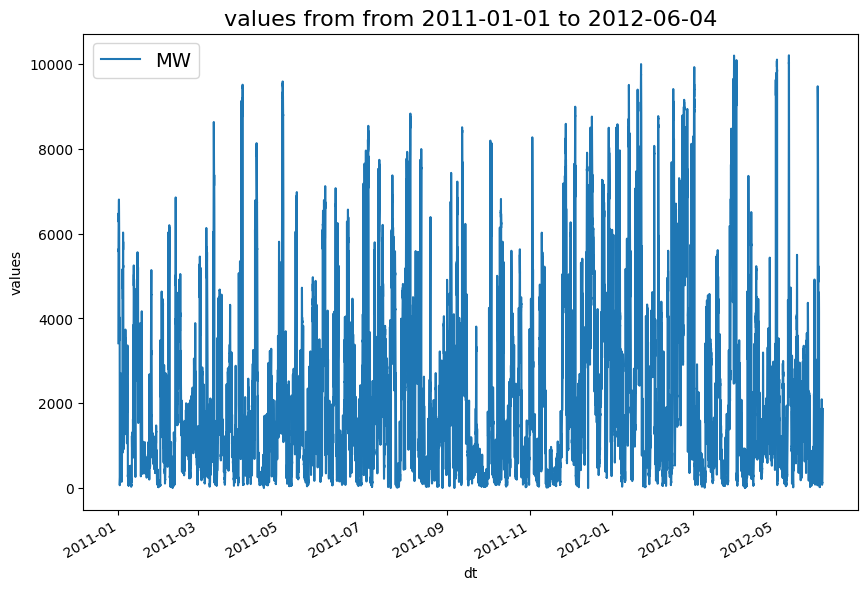

In [ ]:
import matplotlib.pyplot as plt
df.plot(figsize=(10, 7))
plt.ylabel("values")
plt.title(f"values from from {date_range}", fontsize=16)
plt.legend(fontsize=14);

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MW,50000.0,2101.08798,2063.855761,0.0,522.0,1435.0,3048.25,10208.0


In [ ]:
time_train[:2], x_train[:2], time_valid[:2], x_valid[:2]

(0   2011-01-01 00:00:00
 1   2011-01-01 00:15:00
 Name: dt, dtype: datetime64[ns],
 0    3416.0
 1    4755.0
 Name: MW, dtype: float64,
 40000   2012-02-21 16:00:00
 40001   2012-02-21 16:15:00
 Name: dt, dtype: datetime64[ns],
 40000    5278.0
 40001    5362.0
 Name: MW, dtype: float64)

In [ ]:
len(time_train), len(x_train), len(time_valid), len(x_valid),

(40000, 40000, 10000, 10000)

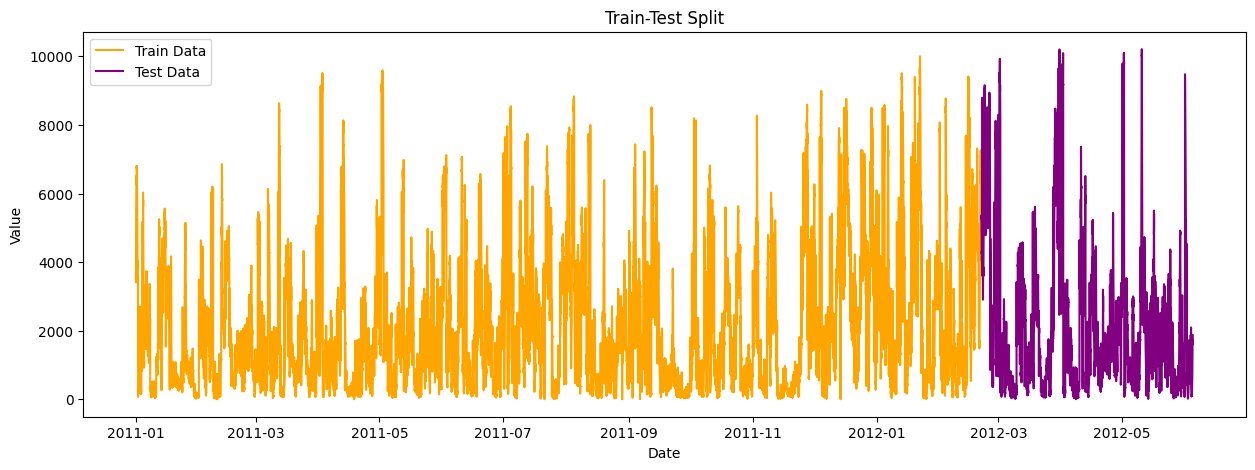

In [ ]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(time_train, x_train, color='orange', label='Train Data')
plt.plot(time_valid, x_valid, color='purple', label='Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
dataset, val_set

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

# **LSTM**


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model_bl = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the training parameters
model_bl.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
# Train the model
history_bl = model_bl.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 34s 19ms/step - loss: 1755.3640 - val_loss: 1492.9065
Epoch 2/10
1250/1250 [==============================] - 16s 12ms/step - loss: 988.2839 - val_loss: 795.8721
Epoch 3/10
1250/1250 [==============================] - 15s 12ms/step - loss: 524.8098 - val_loss: 553.7314
Epoch 4/10
1250/1250 [==============================] - 16s 12ms/step - loss: 335.9855 - val_loss: 371.4703
Epoch 5/10
1250/1250 [==============================] - 16s 13ms/step - loss: 260.5960 - val_loss: 314.6245
Epoch 6/10
1250/1250 [==============================] - 16s 13ms/step - loss: 229.7703 - val_loss: 237.8281
Epoch 7/10
1250/1250 [==============================] - 16s 13ms/step - loss: 220.5684 - val_loss: 199.8091
Epoch 8/10
1250/1250 [==============================] - 20s 16ms/step - loss: 203.5006 - val_loss: 179.1137
Epoch 9/10
1250/1250 [==============================] - 20s 16ms/step - loss: 205.5265 - val_loss: 165.8624
Epoch 10/10
1250/1250 [===

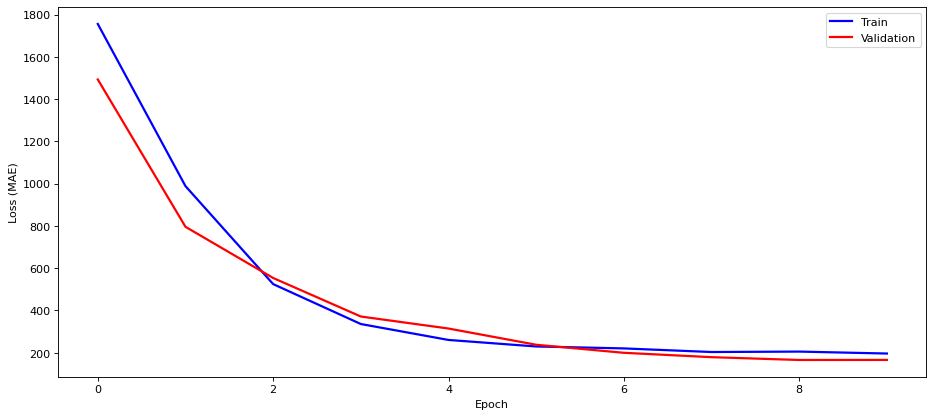

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_bl['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_bl['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model_bl = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_bl.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [ ]:
history_bl = model_bl.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 23s 13ms/step - loss: 2066.7205 - val_loss: 2205.8704
Epoch 2/10
1250/1250 [==============================] - 15s 12ms/step - loss: 2030.6051 - val_loss: 2103.1943
Epoch 3/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1739.8458 - val_loss: 1650.3113
Epoch 4/10
1250/1250 [==============================] - 17s 14ms/step - loss: 1485.9275 - val_loss: 1612.7251
Epoch 5/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1465.1100 - val_loss: 1637.6294
Epoch 6/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1458.6093 - val_loss: 1653.9775
Epoch 7/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1459.9058 - val_loss: 1657.6047
Epoch 8/10
1250/1250 [==============================] - 17s 13ms/step - loss: 1461.5278 - val_loss: 1656.5599
Epoch 9/10
1250/1250 [==============================] - 16s 13ms/step - loss: 1461.3877 - val_loss: 1655.3562
Epoch 10/1

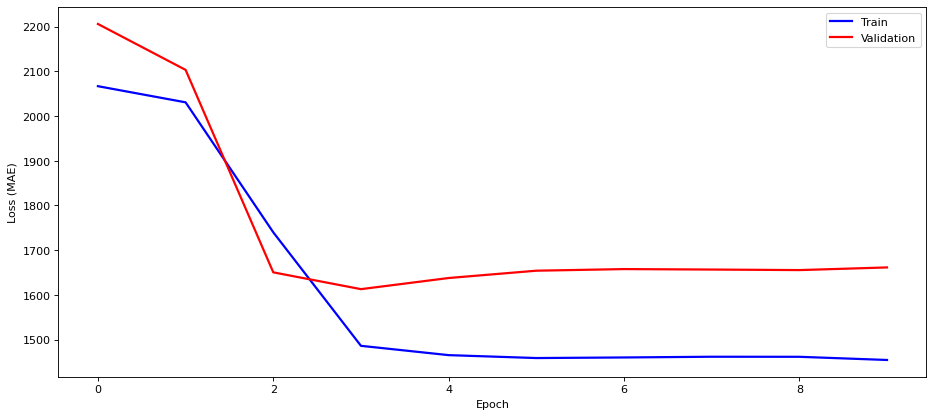

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_bl['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_bl['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Build the model
model_bl = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_bl.compile(optimizer=keras.optimizers.SGD(momentum=0.5, learning_rate = 0.0001), loss='mae')

In [ ]:
history_bl = model_bl.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 23s 13ms/step - loss: 2058.9824 - val_loss: 2161.8132
Epoch 2/10
1250/1250 [==============================] - 17s 14ms/step - loss: 1668.7278 - val_loss: 1615.0780
Epoch 3/10
1250/1250 [==============================] - 20s 16ms/step - loss: 1444.8323 - val_loss: 1686.0717
Epoch 4/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1458.5604 - val_loss: 1681.7443
Epoch 5/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1458.5488 - val_loss: 1681.3964
Epoch 6/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1456.3630 - val_loss: 1685.7772
Epoch 7/10
1250/1250 [==============================] - 16s 13ms/step - loss: 1460.1407 - val_loss: 1680.8990
Epoch 8/10
1250/1250 [==============================] - 16s 12ms/step - loss: 1463.9998 - val_loss: 1676.9437
Epoch 9/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1466.8365 - val_loss: 1672.5204
Epoch 10/1

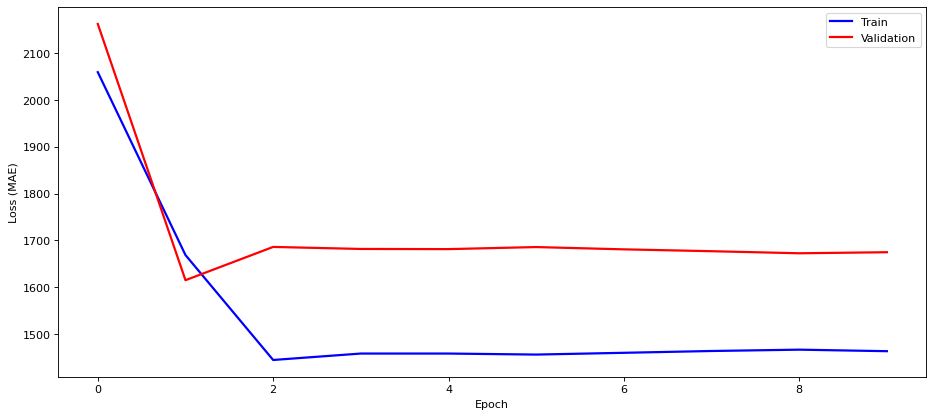

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_bl['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_bl['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Build the model
model_bl = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_bl.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001), loss='mae')

In [ ]:
history_bl = model_bl.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 26s 14ms/step - loss: 1860.3030 - val_loss: 1732.1401
Epoch 2/10
1250/1250 [==============================] - 16s 13ms/step - loss: 1268.1632 - val_loss: 1104.9458
Epoch 3/10
1250/1250 [==============================] - 17s 13ms/step - loss: 755.5355 - val_loss: 742.7878
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 488.4181 - val_loss: 531.4764
Epoch 5/10
1250/1250 [==============================] - 17s 14ms/step - loss: 366.2580 - val_loss: 431.9541
Epoch 6/10
1250/1250 [==============================] - 15s 12ms/step - loss: 308.7145 - val_loss: 403.0281
Epoch 7/10
1250/1250 [==============================] - 15s 12ms/step - loss: 278.9854 - val_loss: 299.5013
Epoch 8/10
1250/1250 [==============================] - 15s 12ms/step - loss: 260.0689 - val_loss: 244.8537
Epoch 9/10
1250/1250 [==============================] - 15s 12ms/step - loss: 250.0439 - val_loss: 275.7071
Epoch 10/10
1250/1250 [=

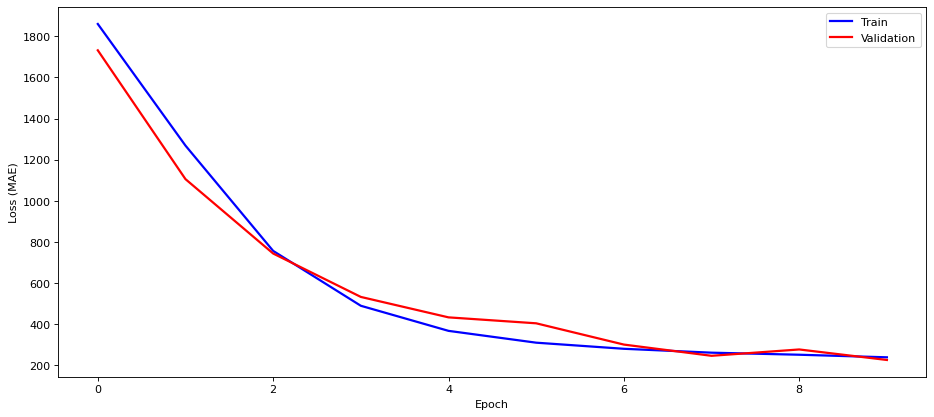

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_bl['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_bl['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# **GRU**

In [ ]:
tf.keras.backend.clear_session()

model_gru = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.GRU(256, return_sequences=True),
  tf.keras.layers.GRU(128),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the training parameters
model_gru.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
history_gru = model_gru.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 15s 9ms/step - loss: 937.3234 - val_loss: 783.4882
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 556.0599 - val_loss: 594.3708
Epoch 3/10
1250/1250 [==============================] - 11s 9ms/step - loss: 400.9240 - val_loss: 476.6862
Epoch 4/10
1250/1250 [==============================] - 11s 9ms/step - loss: 321.6938 - val_loss: 383.9645
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 275.3958 - val_loss: 340.0323
Epoch 6/10
1250/1250 [==============================] - 12s 10ms/step - loss: 247.3547 - val_loss: 290.3085
Epoch 7/10
1250/1250 [==============================] - 11s 9ms/step - loss: 224.8487 - val_loss: 254.8476
Epoch 8/10
1250/1250 [==============================] - 17s 13ms/step - loss: 212.1335 - val_loss: 245.8351
Epoch 9/10
1250/1250 [==============================] - 13s 10ms/step - loss: 207.0831 - val_loss: 220.1118
Epoch 10/10
1250/1250 [===========

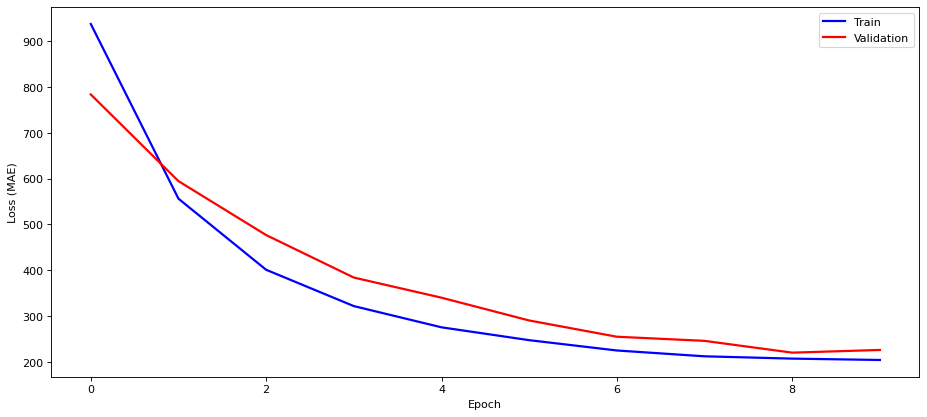

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_gru['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_gru['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

model_gru = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.GRU(256, return_sequences=True),
  tf.keras.layers.GRU(128),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_gru.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss='mae')

In [ ]:
history_gru = model_gru.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 17s 12ms/step - loss: 1416.4540 - val_loss: 1779.4608
Epoch 2/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1416.7770 - val_loss: 1828.8011
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1421.6748 - val_loss: 1732.8766
Epoch 4/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1424.0653 - val_loss: 1764.5333
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1424.7257 - val_loss: 1766.2535
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1424.4111 - val_loss: 1782.7727
Epoch 7/10
1250/1250 [==============================] - 13s 10ms/step - loss: 1427.8888 - val_loss: 1743.0944
Epoch 8/10
1250/1250 [==============================] - 19s 15ms/step - loss: 1429.2142 - val_loss: 1762.4691
Epoch 9/10
1250/1250 [==============================] - 15s 12ms/step - loss: 1424.5660 - val_loss: 1762.1002
Epoch 10/10
12

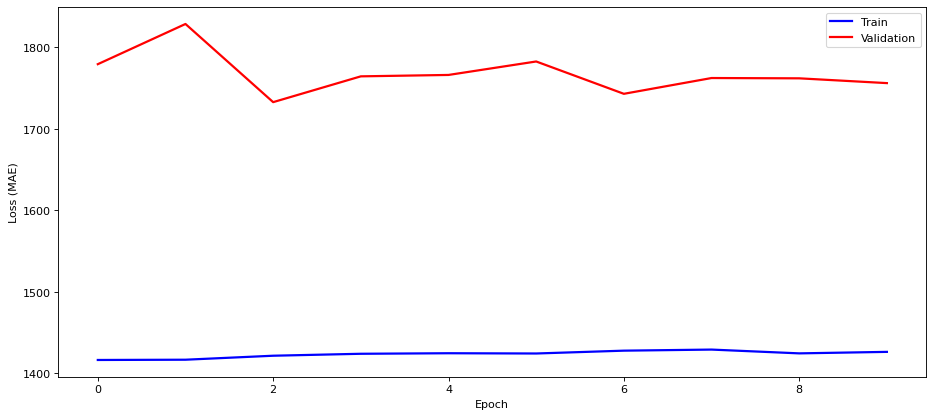

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_gru['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_gru['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

model_gru = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.GRU(256, return_sequences=True),
  tf.keras.layers.GRU(128),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_gru.compile(optimizer=keras.optimizers.SGD(momentum=0.5, learning_rate = 0.0001), loss='mae')

In [ ]:
history_gru = model_gru.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 14s 9ms/step - loss: 1416.1448 - val_loss: 1773.3597
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1419.7971 - val_loss: 1864.7727
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1422.4601 - val_loss: 1801.7390
Epoch 4/10
1250/1250 [==============================] - 11s 8ms/step - loss: 1417.6733 - val_loss: 1917.5557
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1422.5762 - val_loss: 1858.1591
Epoch 6/10
1250/1250 [==============================] - 14s 11ms/step - loss: 1421.0002 - val_loss: 1790.6622
Epoch 7/10
1250/1250 [==============================] - 13s 10ms/step - loss: 1422.3748 - val_loss: 1807.3695
Epoch 8/10
1250/1250 [==============================] - 16s 12ms/step - loss: 1421.0228 - val_loss: 1845.9700
Epoch 9/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1421.3523 - val_loss: 1819.7897
Epoch 10/10
125

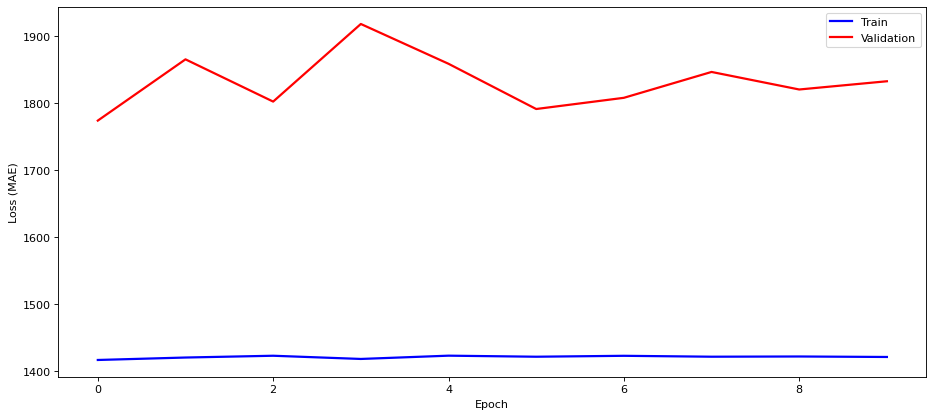

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_gru['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_gru['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

model_gru = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.GRU(256, return_sequences=True),
  tf.keras.layers.GRU(128),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_gru.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001), loss='mae')

In [ ]:
history_gru = model_gru.fit(dataset,epochs=10, validation_data=val_set).history

Epoch 1/10
1250/1250 [==============================] - 24s 15ms/step - loss: 914.1360 - val_loss: 785.5862
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 556.9304 - val_loss: 569.5705
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 410.0522 - val_loss: 549.3918
Epoch 4/10
1250/1250 [==============================] - 11s 9ms/step - loss: 340.3200 - val_loss: 451.3372
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 297.5688 - val_loss: 366.7338
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 267.6719 - val_loss: 396.8355
Epoch 7/10
1250/1250 [==============================] - 11s 9ms/step - loss: 247.7889 - val_loss: 290.2387
Epoch 8/10
1250/1250 [==============================] - 13s 10ms/step - loss: 237.9822 - val_loss: 273.1628
Epoch 9/10
1250/1250 [==============================] - 11s 9ms/step - loss: 227.2674 - val_loss: 335.9984
Epoch 10/10
1250/1250 [===========

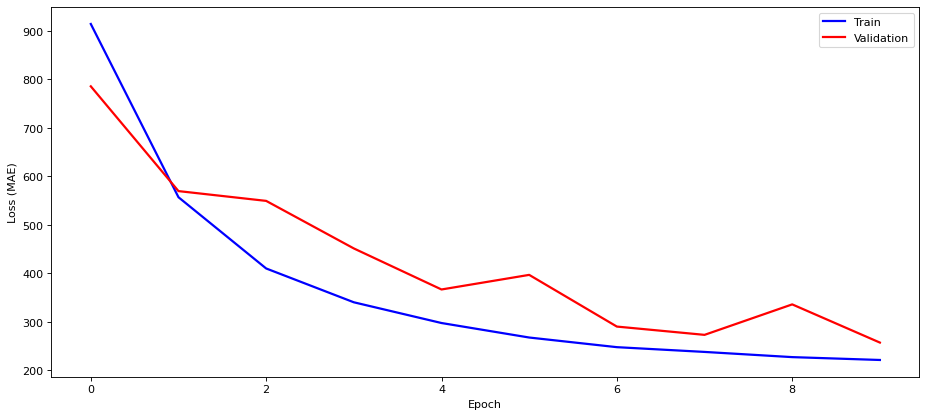

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_gru['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_gru['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(df, df['MW'], test_size=0.2, shuffle=False)

In [ ]:
df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


# **Hyperparameter**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# Определение диапазонов значений для случайного поиска
param_dist = {
'n_estimators': randint(50, 100),
'max_depth': [None, 10, 20],
'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_model = RandomForestRegressor()
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv=5, verbose=2, n_jobs=-1)

In [ ]:
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7dd3b33034c0>},
                   verbose=2)

In [ ]:
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 96}
Best Cross-Validation Score: 0.9999975486511982


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = random_search.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 42.17927606336771
Mean Absolute Error: 0.47514791666666223
R^2 Score: 0.9999921739543299
